# Learning quantum models from quantum or classical data (H.J. Kappen, 2020)

このノートブックは上記論文中の4章の1つ目の実験を再現するものである。  
This notebook reproduces the result of the first example in Sec. 4 of the paper.

---

## Setup

In [1]:
import quimb as qu
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# define number of sites == number of qubits (each site is a 2-level system)
n = 10

## Target state

論文に記載されている実験設定は以下の通りである。  
The paper describes the setting as follows.

- couplings $w^{x,y,z}_{ij} = −1$ for nearest neighbors and $w^{x,y,z}_{ij} = 0$ otherwise
- external fields $w^{x,y,z}_i = 0$

ただし、反強磁性の系の場合、カップリング係数は正のはずなので、論文中の-1は誤植であると思われる。  
However, -1 in the paper is probably a typographical error, because the coupling constants of anti-ferromagnetic system should be positive.

In [3]:
target_wij = (4, 4, 4)  # not 1, because this is the coefficients of spin operators, not pauli operators
target_wi = (0, 0, 0)

# create the Hamiltonian of the TFIM
target_tfim = qu.ham_heis(n, target_wij, target_wi, cyclic=True)

ここでは、target_betaに十分大きい値を設定することにより、$\beta = \infty$の実験結果を再現する。  
Here we reproduce the case $\beta = \infty$ by setting a large value for target_beta.

In [4]:
# fix the temperature of the target state
target_beta = 10000.0

In [5]:
target_eta = qu.thermal_state(target_tfim, target_beta)

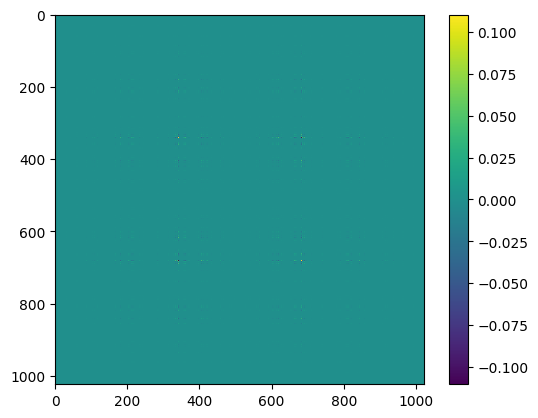

In [6]:
_ = plt.imshow(target_eta, interpolation='nearest')
_ = plt.colorbar()

密度行列の可視化からは何も情報は得られない。  
Visualizing the density matrix reveals almost nothing.

In [7]:
target_probs = qu.eigvalsh(target_eta)

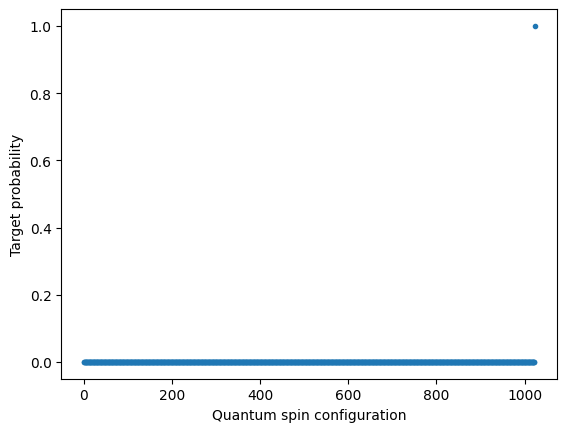

In [8]:
_ = plt.plot(target_probs, '.')
_ = plt.ylabel("Target probability")
_ = plt.xlabel("Quantum spin configuration")

target_betaに大きい値を設定している（ほぼ絶対零度に対応）ため、ほとんどの確率で基底状態にある。  
Since we set a large value for target_beta (almost zero temperature), it is most likely in the ground state.

In [9]:
def plot_quantum_statistics(n, state):
    dims = (2,) * n
    
    q_stats = dict()
    for k in ["X", "Y", "Z"]:
        q_stats[k] = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if i == j:
                    continue
                xi = qu.ikron(qu.pauli(k), dims, [i])
                xj = qu.ikron(qu.pauli(k), dims, [j])
                xixj_expect = qu.expec(state, xi @ xj)
                q_stats[k][i, j] = xixj_expect
    
    fig, axes = plt.subplots(figsize=(10, 3), ncols=3)
    for i, k in enumerate(["X", "Y", "Z"]):
        ax = axes[i]
        m = ax.imshow(q_stats[k], cmap="gray")
        ax.set_title(f"<{k}i{k}j>")
        fig.colorbar(m, ax=ax)
    fig.tight_layout()
    plt.show()

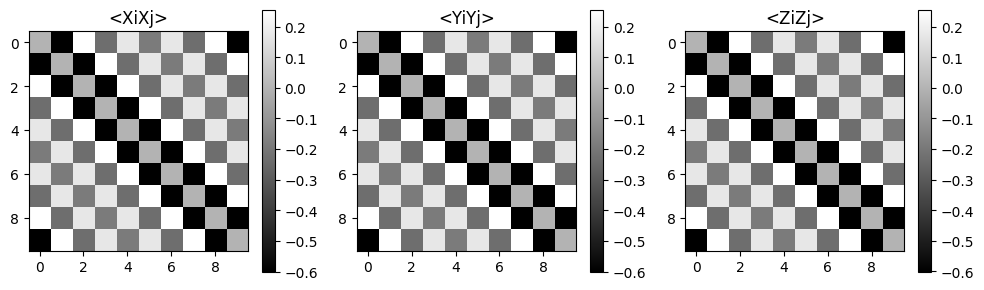

In [10]:
plot_quantum_statistics(n, target_eta)

この図は、論文中の図1aの2段目の再現である。  
This figure is a reproduction of the second row of Figure 1a in the paper.

## QBM definition

In [11]:
# function to create h0 for the TFIM: this is the two-site term
def h_two_sites(n, k, i, j):
    dims = (2,) * n
    return qu.ikron(qu.pauli(k), dims, [i, j])

# function to create h1 for the TFIM: this is the transverse-fiels term (put the minus sign in front)
def h_single_site(n, k, i):
    dims = (2,) * n
    return -qu.ikron(qu.pauli(k), dims, [i])

In [12]:
h0 = []
for k in ["X", "Y", "Z"]:
    for i in range(10):
        for j in range(i+1, 10):
            h0.append(h_two_sites(n, k, i, j))
h1 = []
for k in ["X", "Y", "Z"]:
    for i in range(10):
        h1.append(h_single_site(n, k, i))

print(len(h0), len(h1))

135 30


In [13]:
rng = np.random.default_rng(seed=1)

In [14]:
# parameters to learn. Set initial values at random
w0 = tuple(rng.normal(0, 1, len(h0)))
w1 = tuple(rng.normal(0, 1, len(h1)))

In [15]:
qbm_tfim = qu.qarray(np.zeros((2**10, 2**10), dtype=complex))
for i in range(len(h0)):
    qbm_tfim += w0[i] * h0[i]
for i in range(len(h1)):
    qbm_tfim += w1[i] * h1[i]

In [16]:
rho_qbm = qu.thermal_state(qbm_tfim, -1.0)

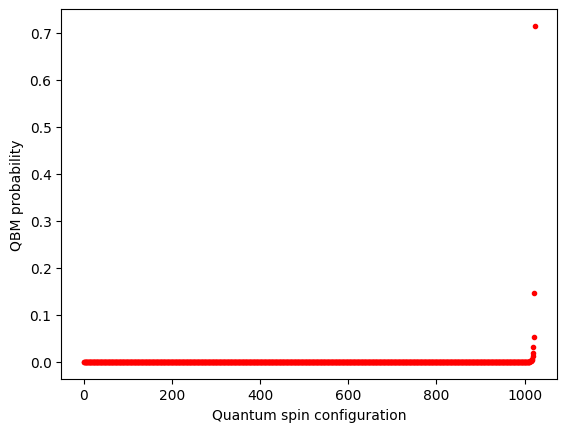

In [17]:
rho_probs = qu.eigvalsh(rho_qbm)
_ = plt.plot(rho_probs, '.r')
_ = plt.ylabel("QBM probability")
_ = plt.xlabel("Quantum spin configuration")

In [18]:
def plot_couplings(n, w0):
    wijk = np.zeros((3, n, n))
    
    idx = 0
    for k in range(3):
        for i in range(n):
            for j in range(i+1, n):
                wijk[k][i][j] = w0[idx]
                wijk[k][j][i] = w0[idx]
                idx += 1
    
    fig, axes = plt.subplots(figsize=(10, 3), ncols=3)
    for i, k in enumerate(["X", "Y", "Z"]):
        ax = axes[i]
        m = ax.imshow(wijk[i], cmap="gray")
        ax.set_title(f"w{k}")
        fig.colorbar(m, ax=ax)
    fig.tight_layout()
    plt.show()

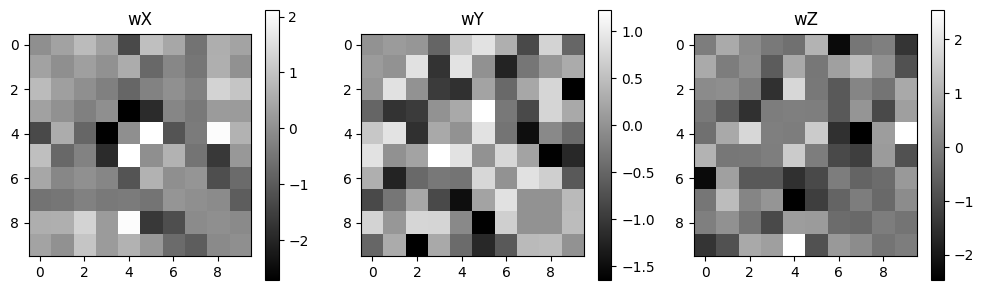

In [19]:
plot_couplings(n, w0)

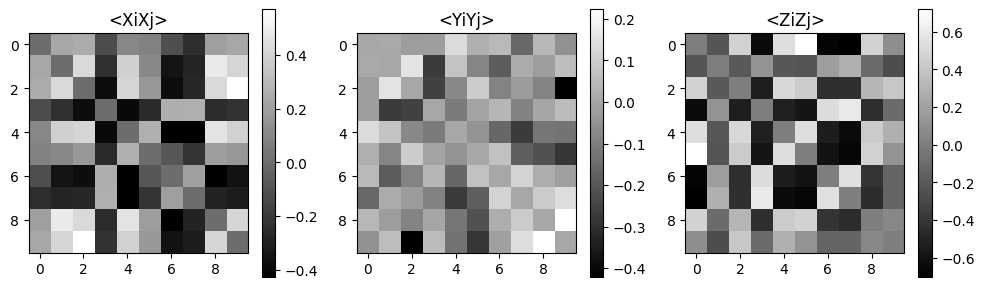

In [20]:
plot_quantum_statistics(n, rho_qbm)

これらの図は、学習前のQBMにおいて、論文中の図1aの3, 4段目と同じ内容を可視化したものである。  
These figures correspond to the third and the forth rows of Figure 1a before the training.

## Quantum relative entropy and its gradients

In [21]:
# function to compute the quantum relative entropy between the target density and the QBM
def qre(eta, h_qbm):
    """Quantum relative entropy

    Args:
        eta (Any): Target density matrix
        h_qbm (Any): Hamiltonian of the QBM
    """
    # h = qu.entropy(eta) # do not use because it has log2 inside
    evals = qu.eigvalsh(eta).clip(1e-300)
    h = np.sum(evals * np.log(evals))
    # use log base e all the way
    evals = qu.eigvalsh(h_qbm).clip(1e-300)
    z = np.sum(np.exp(evals))
    eta_stat = qu.expec(eta, h_qbm)
    return h-eta_stat+qu.log(z)

In [22]:
def compute_grads(hi, eta, rho):
    """Compute gradients given a list of hamiltonian terms (operators)

    Args:
        hi (List, Tuple): A list of hamiltonian terms
        eta (Any): The target density matrix
        rho (Any): The QBM density matrix

    Returns:
        np.ndarray: The array of the gradients
    """
    grads = []
    for h in hi:
        rho_expect = qu.expec(rho, h).real
        eta_expect = qu.expec(eta, h).real
        grads.append(rho_expect-eta_expect)
    return np.array(grads)

In [23]:
# gradient descent!
def update_params(params, grads, gamma):
    return params - gamma * grads

In [24]:
print(f"Relative entropy: {qre(target_eta, qbm_tfim)}")
print(f"Gradients: {compute_grads(h0 + h1, target_eta, rho_qbm)}")

Relative entropy: 32.32433031753483
Gradients: [ 8.29128098e-01 -9.15399860e-03  1.01583360e-01 -7.23720271e-02
  2.69729348e-01 -2.90488081e-01 -1.47728552e-02 -6.07146718e-02
  8.27065160e-01  1.02361215e+00 -4.91966740e-01  6.17417552e-01
 -6.97786083e-02 -1.58452416e-01 -4.60304881e-01  7.19710715e-01
  1.52970279e-01  2.26105344e-01  1.51597189e-01  4.00091206e-01
 -5.48059605e-01 -8.53213763e-02  2.47630072e-01  8.02344350e-01
  2.10937569e-01 -5.16405428e-01  4.82822826e-01  8.26008668e-02
 -6.54305401e-02 -4.03844910e-01  8.64064732e-01 -6.81928356e-01
 -1.96903885e-01  2.88108342e-01  5.75892401e-01  5.13676052e-01
 -4.73401195e-01  4.18070964e-01 -7.08273827e-03  7.98364141e-01
 -6.80848788e-01 -1.26192309e-01  3.12388234e-01 -5.71208515e-01
  1.00948007e+00  6.08228794e-01 -2.78482655e-01  2.09445238e-01
 -4.09701448e-02  2.08204834e-01 -1.27070972e-01  7.33292289e-02
 -2.11764992e-01  5.47766756e-01  7.54554210e-01 -5.24547177e-01
  3.02026608e-01 -2.58109756e-01 -1.1252526

## Training of the QBM

計算時間がかかるため、エポック数は論文の設定よりもかなり少ないが100とした。  
Due to the long computation time, the number of epochs is set to 100, a value considerably less than the paper.

In [25]:
# learning rate
gamma = 0.2
# number of epochs
epochs = 100

In [26]:
# initial parameter
new_params = np.array(w0 + w1)

# stop when gradient is smaller than epsilon, at the final number of epochs
eps = 1e-6
# keep track of loss and gradients
qre_hist = []
grad_hist = []
for i in tqdm(range(epochs)):
    # create qbm hamiltonians
    qbm_tfim = qu.qarray(np.zeros((2**n, 2**n), dtype=complex))
    for j in range(len(h0)):
        qbm_tfim += new_params[:-3*n][j] * h0[j]
    for j in range(len(h1)):
        qbm_tfim += new_params[-3*n:][j] * h1[j]
    # qbm_tfim = qbm_tfim.real  # why?
    qre_hist.append(qre(target_eta, qbm_tfim))
    # create qbm state
    rho = qu.thermal_state(qbm_tfim, -1.0)
    # grad and update
    grads = compute_grads(h0 + h1, target_eta, rho)
    grad_hist.append(np.abs(grads))
    new_params = update_params(new_params, grads, gamma)
    # print diagnostic
    if (i % 10) == 0:
        print(f"Quantum relative entropy: {qre_hist[-1]}")
        print(f"Max abs gradient: {np.max(grad_hist[-1])}")
    if np.max(grad_hist[-1]) < eps:
        print(f"Max gradient smaller than precision")
        break

  1%|▊                                                                               | 1/100 [00:49<1:21:35, 49.44s/it]

Quantum relative entropy: 32.32433031753483
Max abs gradient: 1.1484274691790652


 11%|████████▋                                                                      | 11/100 [10:24<1:22:18, 55.49s/it]

Quantum relative entropy: 5.059022162143151
Max abs gradient: 0.5161699697927215


 21%|█████████████████                                                                | 21/100 [18:31<57:56, 44.01s/it]

Quantum relative entropy: 2.0959276075451747
Max abs gradient: 0.23394892718449395


 31%|█████████████████████████                                                        | 31/100 [25:33<49:03, 42.66s/it]

Quantum relative entropy: 1.1994319072258541
Max abs gradient: 0.12014462303826795


 41%|█████████████████████████████████▏                                               | 41/100 [33:33<50:47, 51.66s/it]

Quantum relative entropy: 0.8281776259220379
Max abs gradient: 0.07448854844070019


 51%|█████████████████████████████████████████▎                                       | 51/100 [41:27<39:06, 47.89s/it]

Quantum relative entropy: 0.6330407678731191
Max abs gradient: 0.05365425679261693


 61%|█████████████████████████████████████████████████▍                               | 61/100 [49:39<33:32, 51.60s/it]

Quantum relative entropy: 0.5135066209960542
Max abs gradient: 0.042662065869310206


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [57:11<21:52, 45.26s/it]

Quantum relative entropy: 0.4330811435873123
Max abs gradient: 0.03556927201977711


 81%|███████████████████████████████████████████████████████████████▉               | 81/100 [1:04:53<14:43, 46.49s/it]

Quantum relative entropy: 0.37552548873357594
Max abs gradient: 0.030534439312405848


 91%|███████████████████████████████████████████████████████████████████████▉       | 91/100 [1:12:35<06:41, 44.65s/it]

Quantum relative entropy: 0.33245806066874906
Max abs gradient: 0.02674383612532394


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:19:05<00:00, 47.45s/it]


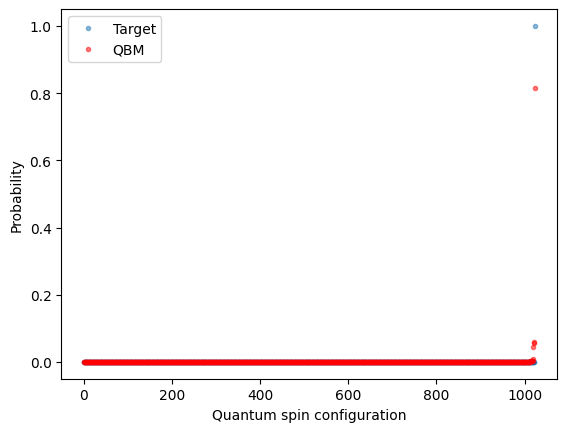

In [27]:
rho_probs = qu.eigvalsh(rho)
_ = plt.plot(target_probs, '.', label="Target", alpha=0.5)
_ = plt.plot(rho_probs,'.r', label="QBM", alpha=0.5)
_ = plt.ylabel("Probability")
_ = plt.xlabel("Quantum spin configuration")
_ = plt.legend()

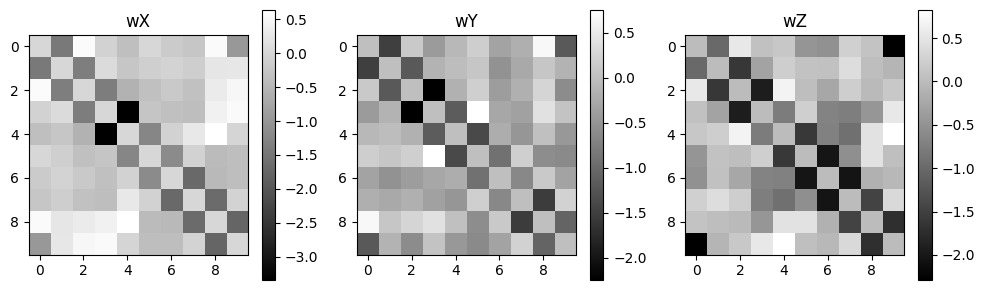

In [28]:
plot_couplings(n, new_params[:-3*n])

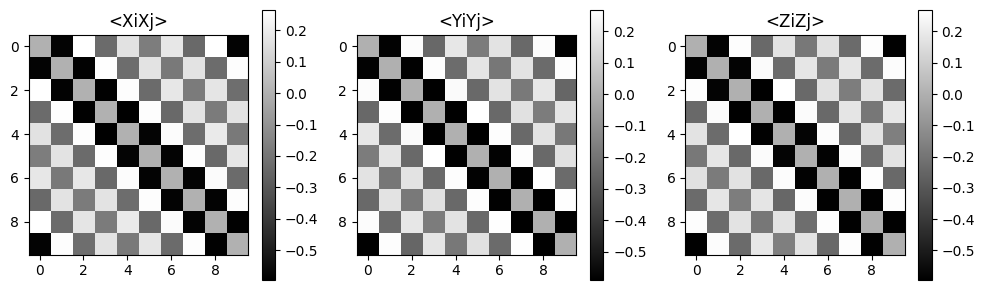

In [29]:
plot_quantum_statistics(n, rho)

これらの図は、論文中の図1aの3, 4段目の再現である。  
学習回数が少ないため、カップリング係数はまだ十分に学習できていないが、初期状態よりもターゲットに近づいている傾向は見て取れる。  
量子統計に関しては、既によくターゲットの値を学習できている。  
This figures are reproductions of the third and the forth row of Figure 1a in the paper.  
Due to the small number of iteration, the coupling coefficients have not yet been learned well, but a trend toward getting closer to the target than in the initial state can be seen.  
As for the quantum statistics, we have already learned the target values well.

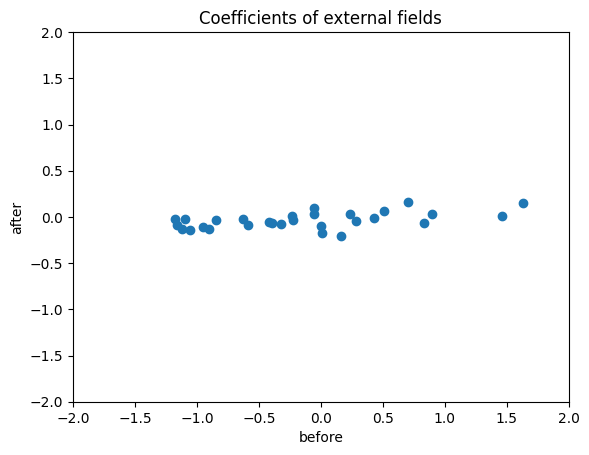

In [30]:
_ = plt.scatter(w1, new_params[-3*n:])
_ = plt.xlim(-2, 2)
_ = plt.ylim(-2, 2)
_ = plt.title("Coefficients of external fields")
_ = plt.xlabel("before")
_ = plt.ylabel("after")

外部磁場の係数は0に近づいており、正しく学習できている。  
The coefficients of the external field are approaching zero and have been learned correctly.

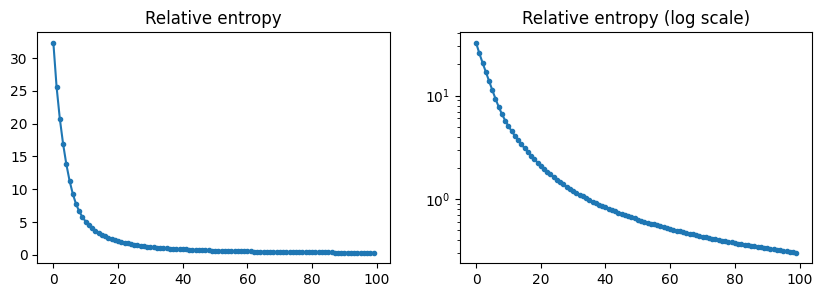

In [31]:
fig, axes = plt.subplots(figsize=(10, 3), ncols=2)
axes[0].plot(qre_hist, marker=".")
axes[1].plot(qre_hist, marker=".")
axes[1].set_yscale('log')
axes[0].set_title("Relative entropy")
axes[1].set_title("Relative entropy (log scale)")
plt.show()

この図は、論文中の図1bの再現である。  
This figure is a reproduction of Figure 1b in the paper.

C:\Users\4034195\AppData\Local\Programs\Python\Pipenv\qc\.venv\lib\site-packages\matplotlib\collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


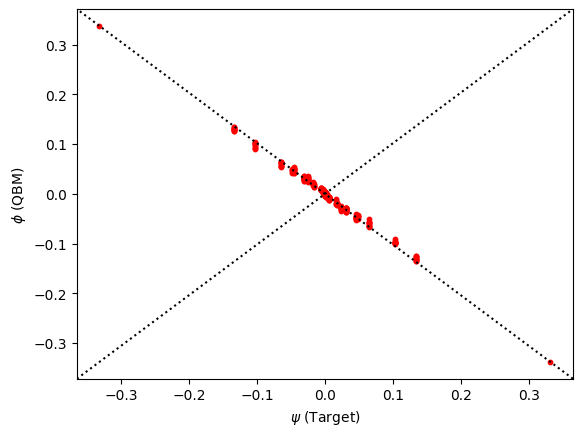

In [32]:
psi = qu.eigh(target_eta)[1][:, -1]
phi = qu.eigh(qbm_tfim)[1][:, -1]

fig, ax = plt.subplots()
ax.scatter(psi, phi, s=10, color="red")
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=":", color="black")
ax.plot([1, 0], [0, 1], transform=ax.transAxes, linestyle=":", color="black")
ax.set_xlabel(r"$\psi$ (Target)")
ax.set_ylabel(r"$\phi$ (QBM)")
plt.show()

この図は、論文中の図1cの再現である。（QBMのみ）  
グローバル位相は反転しているが、正しい係数を学習できつつあるように見える。  
This figure is a reproduction of Figure 1c in the paper. (QBM only)  
The global phase is inverted, but it appears to be learning the correct coefficients.